In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from script_automation.automation_script_process_load import run_automation_process_load_data
from script_automation.automation_script_process_load_prueba import run_automation_process_load_data_prueba
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

In [2]:
df = pd.read_parquet('../../data_parquet/train_data.parquet')

In [ ]:
df_processed = run_automation_process_load_data(df) # Procesar datos

In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153078 entries, 11 to 167999
Data columns (total 21 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   generation_hydro_pumped_storage_consumption  153078 non-null  int64  
 1   generation_solar                             153078 non-null  int64  
 2   generation_fossil_gas                        153078 non-null  int64  
 3   generation_wind_onshore                      153078 non-null  float64
 4   generation_fossil_oil                        153078 non-null  int64  
 5   generation_hydro_water_reservoir             153078 non-null  float64
 6   generation_hydro_run_of_river_and_poundage   153078 non-null  float64
 7   generation_nuclear                           153078 non-null  int64  
 8   generation_fossil_hard_coal                  153078 non-null  float64
 9   price_actual                                 153078 non-null  f

In [5]:
# Separar en variables dependiente y independiente
y = df_processed['total_load_actual'].values
df_processed.drop('total_load_actual', axis = 1, inplace=True)
X = df_processed

In [6]:
# Escalamos variables numericos
def standarize(X):
    numeric_columns = X.select_dtypes(include='number').drop(['day','hour'], axis = 1)
    scaler = StandardScaler()

    X[numeric_columns.columns] = scaler.fit_transform(numeric_columns)

    return X

In [7]:
X = standarize(X)

In [8]:
len(X)

153078

In [9]:
# Dividimos en validacion y entrenamiento
X_train = X[:133084]
y_train = y[:133084]
X_val = X[-20000:]
y_val = y[-20000:]

### Modelado

In [10]:
# Regrsion lineal basica
linear_regression_model = LinearRegression(n_jobs=-1)
linear_regression_model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [11]:
# predicción demanda energética
pred_load = linear_regression_model.predict(X_val)

In [12]:
print('raiz cuadratica medio en validación linear regress:',round(root_mean_squared_error(y_val, pred_load),2))

raiz cuadratica medio en validación linear regress: 0.0


In [13]:
print('La evaluación de la demanda en la regresion lineal es de:',cross_val_score(linear_regression_model, X_train, y_train, cv=10).mean())

La evaluación de la demanda en la regresion lineal es de: 1.0


**Conjunto de prueba**

In [14]:
df = pd.read_parquet('../../data_parquet/test_data.parquet')

In [15]:
df_processed_prueba = run_automation_process_load_data_prueba(df) # Procesar datos

In [16]:
len(df)

10405

In [17]:
len(df_processed_prueba)

10405

In [18]:
# Separar en variables dependiente y independiente
y_test = df_processed_prueba['total_load_actual'].values
df_processed_prueba.drop('total_load_actual', axis = 1, inplace=True)
X_test = df_processed_prueba

In [19]:
X_test = standarize(X_test) # estandarizacion 

In [20]:
# Ordenar columnas respecto a df de entrenamiento
X_test = X_test.reindex(columns=X_train.columns)

In [21]:
pred_load_test = linear_regression_model.predict(X_test) # Prediccion 

In [22]:
y_test[:10]

array([32270, 32688, 32404, 32303, 31667, 30216, 29435, 29258, 30235,
       32097], dtype=int64)

In [23]:
pred_load_test = pred_load_test.round()

In [24]:
pred_load_test[:10]

array([28342., 29631., 31547., 31447., 30823., 29398., 28656., 28511.,
       29491., 31320.])

In [25]:
print('raiz cuadratica medio en conjunto de prueba:',round(root_mean_squared_error(y_test, pred_load_test),2))

raiz cuadratica medio en conjunto de prueba: 747.16


In [26]:
# Metrica en conjunto de prueba (coeficiente de determinación)
r2 = r2_score(y_test, pred_load_test)
print('Score en conjunto de prueba:',round(r2,2))

Score en conjunto de prueba: 0.97


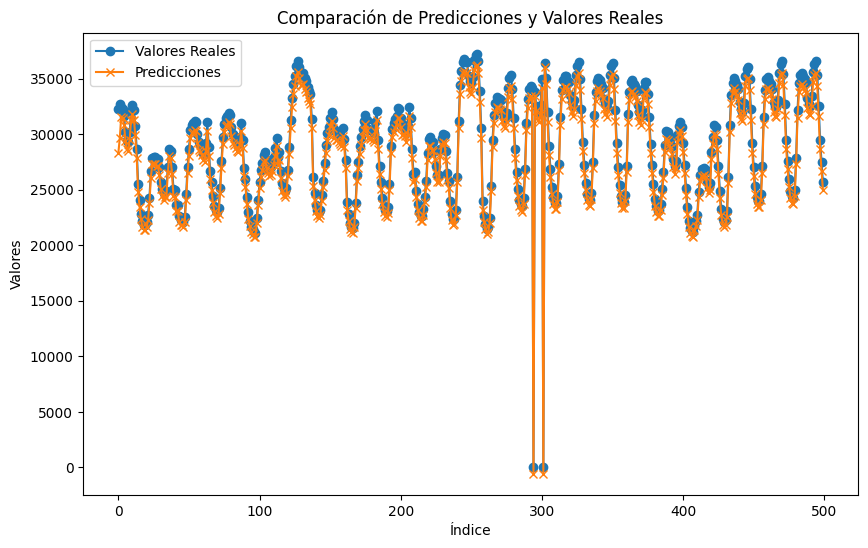

In [27]:
# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(y_test[:500], label='Valores Reales', marker='o')
plt.plot(pred_load_test[:500], label='Predicciones', marker='x')

plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Comparación de Predicciones y Valores Reales')
plt.legend()

plt.show()

El mejor modelo hasta ahora es la regresión lineal con 0.97 en conjunto de datos no vistos